In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import random
import os

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Set Seed
seed = 0
random.seed(seed)
np.random.seed(seed)

# Set path
dataset_path = "dataset"
result_csv_path = f"{dataset_path}/22_생산정보.csv"
energy_use_csv_path = f"{dataset_path}/22_에너지사용정보.csv"

In [2]:
# 데이터 전처리 및 에너지 사용량 데이터 정리.
result = pd.read_csv(energy_use_csv_path, encoding='cp949')
result.drop(['water_cost', 'fertilizer_cost', 'heating_energy_cost',
            'CO2_cost', 'mist_cost'], axis=1, inplace=True)
result = result.rename(
    columns={'measDate': 'measure_date', 'farm_cde': 'form_id'})
result = result.reset_index(drop=True)
result['form_id'] = result['form_id'].replace(
    {'천지인술': 'id1', 'Trigger': 'id2', '이삭줍는 알파고': 'id3', '토마토명가': 'id4'})
result.to_csv("energy_usage.csv", index=False, encoding='utf-8')
result.tail(2)

,measure_date,form_id,water_usage,fertilizer_usage,heating_energy_usage,CO2_usage,mist_usage_time
278,2022-12-08,id4,1950,5226,74880,0,3
279,2022-12-09,id4,920,2121,53230,0,3


In [3]:
# 수확된 작물의 3등급 이상의 무게 합계를 측정.
result = pd.read_csv(result_csv_path, encoding='cp949')
result = result[result['itemGrade'].isin(['1등급', '2등급', '3등급'])]
result = result.groupby(['farm_cde']).sum().reset_index()
result.rename(columns={'itemGrade': 'grade',
              'outtrn': 'yield_kg'}, inplace=True)
result_dict = result.to_dict()['yield_kg']

# 각각의 결과를 form_id에 매핑.
yield_result = {
    'id1': round(result_dict[2], 4),
    'id2': round(result_dict[0], 4),
    'id3': round(result_dict[1], 4),
    'id4': round(result_dict[3], 4)
}
yield_result

{'id1': 36.82, 'id2': 89.295, 'id3': 62.906, 'id4': 104.692}

In [4]:
# 데이터 로드 및 전처리
data = pd.read_csv('energy_usage.csv')
data['yield'] = data['form_id'].map(yield_result)

features = ['water_usage', 'fertilizer_usage',
            'heating_energy_usage', 'CO2_usage', 'mist_usage_time']
X = data[features]  # 독립 변수(에너지 사용량)
y = data['yield']  # 타겟 변수(수확량)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
# 랜덤 포레스트 모델을 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

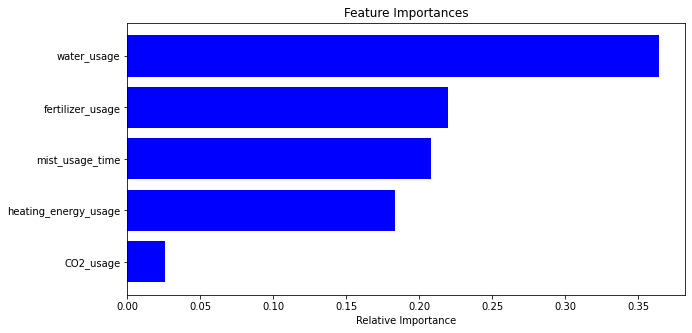

In [6]:
# 특성 중요도 추출 및 시각화
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

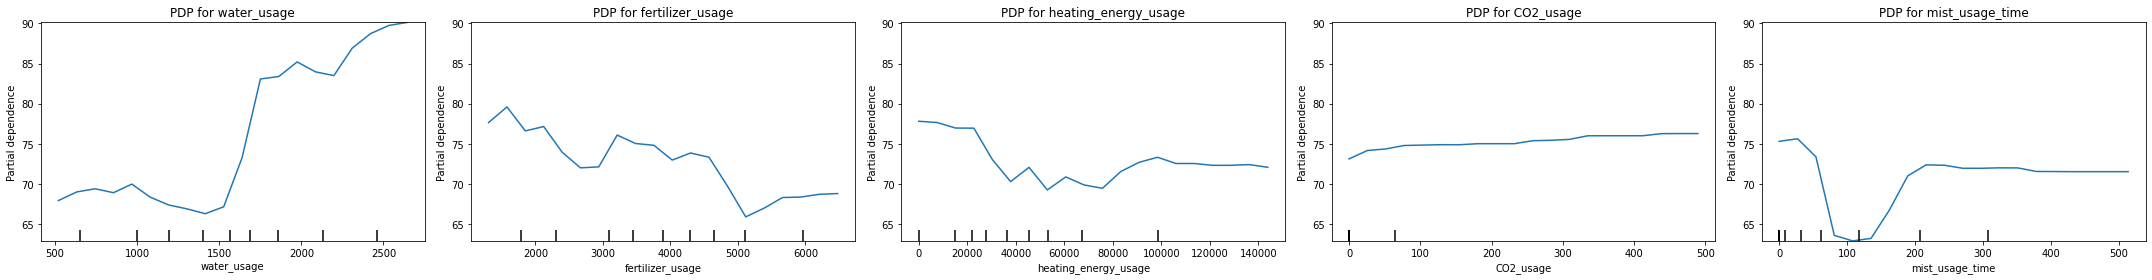

In [7]:
# 부분 의존성 플롯 (Partial Dependence Plots, PDP) 플롯 생성
fig, ax = plt.subplots(figsize=(30, 4), ncols=len(features))
plot_partial_dependence(model, X, features=features,
                        n_jobs=3, grid_resolution=20, ax=ax)

# 플롯 타이틀 및 레이블 설정
for a, feature in zip(ax, features):
    a.set_title(f'PDP for {feature}')
    a.set_ylabel('Partial dependence')

plt.tight_layout()
plt.show()

In [8]:
# 유전 알고리즘 설정(첫 번째 인자는 클래스 이름)
creator.create("FitnessMax", base.Fitness,
               weights=(1.0,))  # 최적화 목표를 적합도 최대화로 설정
creator.create("Individual", list, fitness=creator.FitnessMax)  # 개체 정의

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)  # 개체 초기화시 유니폼 분포에서 난수 생성
toolbox.register("individual", tools.initRepeat,  # len(features)만큼 attr_float 함수를 호출하여 개체 생성
                 creator.Individual, toolbox.attr_float, n=len(features))
toolbox.register("population", tools.initRepeat,
                 list, toolbox.individual)  # 개체군을 생성


def evalModel(individual):
    modified_input = X_test * individual
    predictions = model.predict(modified_input)
    return (mean_squared_error(y_test, predictions),)


toolbox.register("evaluate", evalModel)  # 평가함수(MSE) 등록
toolbox.register("mate", tools.cxTwoPoint)  # 교차함수(두 점 교차) 등록
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma=0.1, indpb=0.2)  # 돌연변이함수(가우시안) 등록
toolbox.register("select", tools.selTournament, tournsize=3)  # 선택함수(토너먼트) 등록

# 유전 알고리즘 실행
population = toolbox.population(n=50)  # 초기 인구 생성
NGEN = 40  # 세대 수
for gen in range(NGEN):
    offspring = algorithms.varAnd(
        population, toolbox, cxpb=0.5, mutpb=0.2)  # 교차와 돌연변이를 적용해 후손 생성
    fits = toolbox.map(toolbox.evaluate, offspring)  # 후손의 적합도 평가
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit  # 적합도 값 업데이트
    population = toolbox.select(offspring, k=len(population))  # 새로운 인구 선택

# 가장 좋은 n개의 해 선택하여 출력.
top_individuals = tools.selBest(population, k=10)
print("Top 10 solutions:")
for ind in top_individuals:
    print(ind, ind.fitness.values)

Top 10 solutions:
[1.2836069731757433, 0.5260009508232162, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1272.2421644880208,)
[1.2836069731757433, 0.5260009508232162, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1272.2421644880208,)
[1.2836069731757433, 0.5260009508232162, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1272.2421644880208,)
[1.2836069731757433, 0.5260009508232162, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1272.2421644880208,)
[1.2836069731757433, 0.5260009508232162, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1272.2421644880208,)
[1.2836069731757433, 0.4541305213174827, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1258.2116142471998,)
[1.2836069731757433, 0.4541305213174827, 0.16809106641418703, 0.4981332317550159, 0.009903059562914974] (1258.2116142471998,)
[1.2836069731757433, 0.4541305213174827, 0.16809106641418703, 0.4981332317550159, 0.0099030595629149

In [9]:
# 가정: 'data'는 각 농장의 일별 에너지 사용 데이터를 포함한 DataFrame
# 스케일링 인자: [물 사용량, 비료 사용량, 난방 에너지, CO2, 안개 사용 시간]
scaling_factors = list(top_individuals[0])

# 데이터에 스케일링 인자 적용
adjusted_data = data.copy()
for i, column in enumerate(features):
    adjusted_data[column] = round(data[column] * scaling_factors[i], 4)

# 조정된 데이터 출력
print(adjusted_data.head())
adjusted_data.to_csv("adjusted_data.csv", index=False, encoding='utf-8')

  measure_date form_id  water_usage  fertilizer_usage  heating_energy_usage  \
0   2022-10-01     id1    1540.3284         1910.4355                0.0000   
1   2022-10-02     id1     115.5246          151.4883                0.0000   
2   2022-10-03     id1     564.7871          763.7534                0.0000   
3   2022-10-04     id1     770.1642          947.8537                0.0000   
4   2022-10-05     id1    1309.2791         1611.6669             3129.8557   

   CO2_usage  mist_usage_time  yield  
0        0.0           1.8420  36.82  
1        0.0           0.0000  36.82  
2        0.0           0.0000  36.82  
3        0.0           0.0000  36.82  
4        0.0           1.0101  36.82  


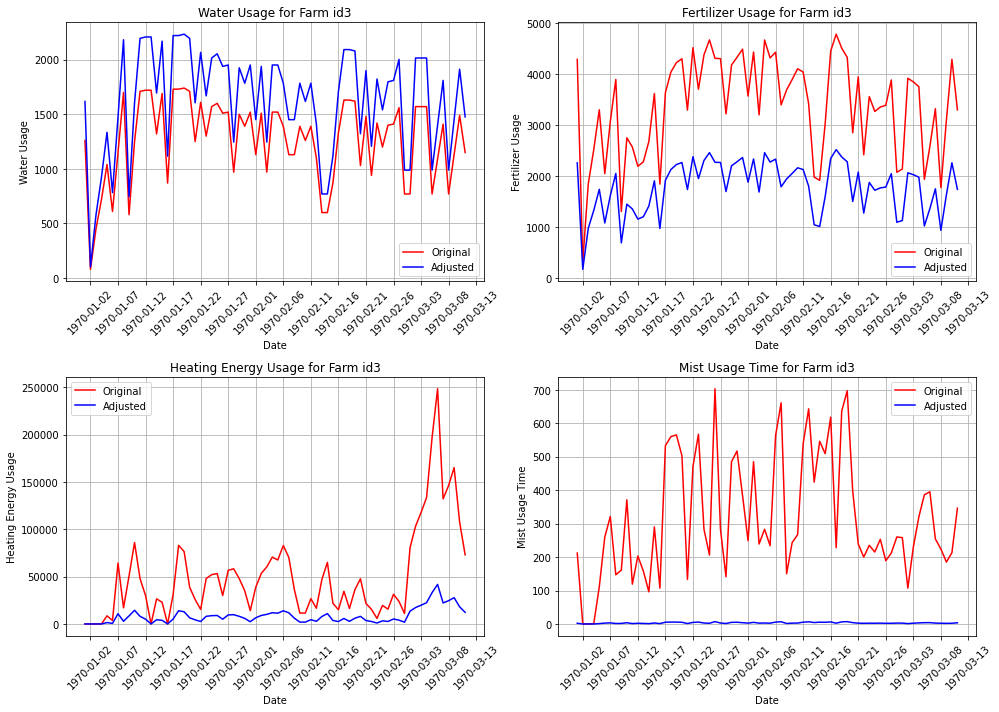

In [10]:
import matplotlib.dates as mdates


def plot_energy_usages_combined(energy_df, adjusted_df, farm_id):
    usage_types = ['water_usage', 'fertilizer_usage',
                   'heating_energy_usage', 'mist_usage_time']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, usage in enumerate(usage_types):
        filtered_energy = energy_df[energy_df['form_id'] == farm_id]
        filtered_adjusted = adjusted_df[adjusted_df['form_id'] == farm_id]

        # Plot on the appropriate subplot
        ax = axes[i]
        ax.plot(filtered_energy['measure_date'],
                filtered_energy[usage], 'r', label='Original')
        ax.plot(filtered_adjusted['measure_date'],
                filtered_adjusted[usage], 'b', label='Adjusted')
        ax.set_title(f'{usage.replace("_", " ").title()} for Farm {farm_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel(f'{usage.replace("_", " ").title()}')

        # Set x-axis to display date every 5 days
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.tick_params(axis='x', rotation=45)

        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# Plot combined graphs
plot_energy_usages_combined(data, adjusted_data, 'id3')

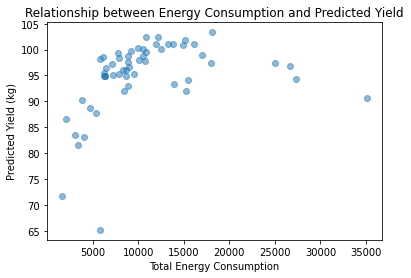

In [11]:
# 수확량 예측과 에너지 소비의 관계 시각화

# 각 개체(가중치 세트)에 대해 테스트 데이터에 적용하여 예측 수확량 계산
predicted_yields = [model.predict(X_test * np.array(ind))
                    for ind in top_individuals]

# 각 개체에 대한 총 에너지 소비량 계산
total_energy_consumption = [
    np.sum(X_test * np.array(ind), axis=1) for ind in top_individuals]

# 개체의 에너지 소비량과 예측 수확량을 플로팅
plt.scatter(total_energy_consumption[0], predicted_yields[0], alpha=0.5)
plt.xlabel('Total Energy Consumption')
plt.ylabel('Predicted Yield (kg)')
plt.title('Relationship between Energy Consumption and Predicted Yield')
plt.show()

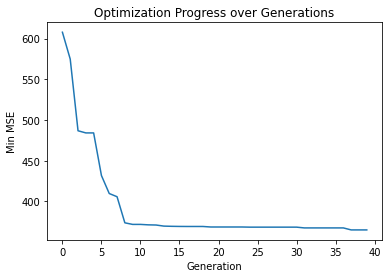

In [12]:
# 유전 알고리즘 설정
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attr_float, n=len(features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalModel(individual):
    modified_input = X_test * individual
    predictions = model.predict(modified_input)
    return (mean_squared_error(y_test, predictions),)


toolbox.register("evaluate", evalModel)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 유전 알고리즘 실행 및 세대별 최소 MSE 기록
population = toolbox.population(n=50)
NGEN = 40
min_mse_per_generation = []

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    min_mse_per_generation.append(
        min(ind.fitness.values[0] for ind in population))

# 최소 MSE 시각화
plt.plot(min_mse_per_generation)
plt.xlabel('Generation')
plt.ylabel('Min MSE')
plt.title('Optimization Progress over Generations')
plt.show()